## Importing dependencies

# 📦 1. Import Libraries

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib  # For saving the model


# 📂 2. Load the Data

Dropped the column `"id"` to avoid column missmatch issue, as the col id is irrelevant to the model training.

In [5]:
df = pd.read_csv(r"C:\CodeClause_Internship_Heart_Disease_Risk_Assessment\heart_train.csv")  # Replace with your filename

df.drop(columns="id", axis=1, inplace=True)  # Drop the 'id' column
# 🎯 3. Separate features and label
X = df.drop("cardio", axis=1)
y = df["cardio"]

# 📊 4. Train-test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ⚙️ 5. Create Pipeline: Scaling + PCA + XGBoost

In [7]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=10)),  # 🧠 Select top 10 features
    ('pca', PCA(n_components=8)),                         # 🎯 Reduce to 8 principal components
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# 🧠 6. Define Hyperparameter Grid for GridSearchCV

In [8]:
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 1.0]
}


# 🔍 7. Grid Search with Cross-Validation

In [9]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\CodeClause_Internship_Heart_Disease_Risk_Assessment\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:49:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'xgb__colsample_bytree': [0.7, 0.8, ...], 'xgb__learning_rate': [0.01, 0.1, ...], 'xgb__max_depth': [3, 5, ...], 'xgb__n_estimators': [100, 200], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


# ✅ 8. Evaluation

In [10]:
y_pred = grid_search.predict(X_test)

# Best parameters

In [11]:
grid_search.best_params_

{'xgb__colsample_bytree': 1.0,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 5,
 'xgb__n_estimators': 200,
 'xgb__subsample': 0.7}

In [12]:
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("📋 Classification Report:\n", classification_report(y_test, y_pred))

🎯 Accuracy: 0.7187142857142857
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.73      0.72      7004
           1       0.72      0.71      0.72      6996

    accuracy                           0.72     14000
   macro avg       0.72      0.72      0.72     14000
weighted avg       0.72      0.72      0.72     14000



# 💾 9. Save the Best Model

In [13]:
joblib.dump(grid_search.best_estimator_, "xgb_heart_model.pkl")

['xgb_heart_model.pkl']

## Looking at the important features used during the training

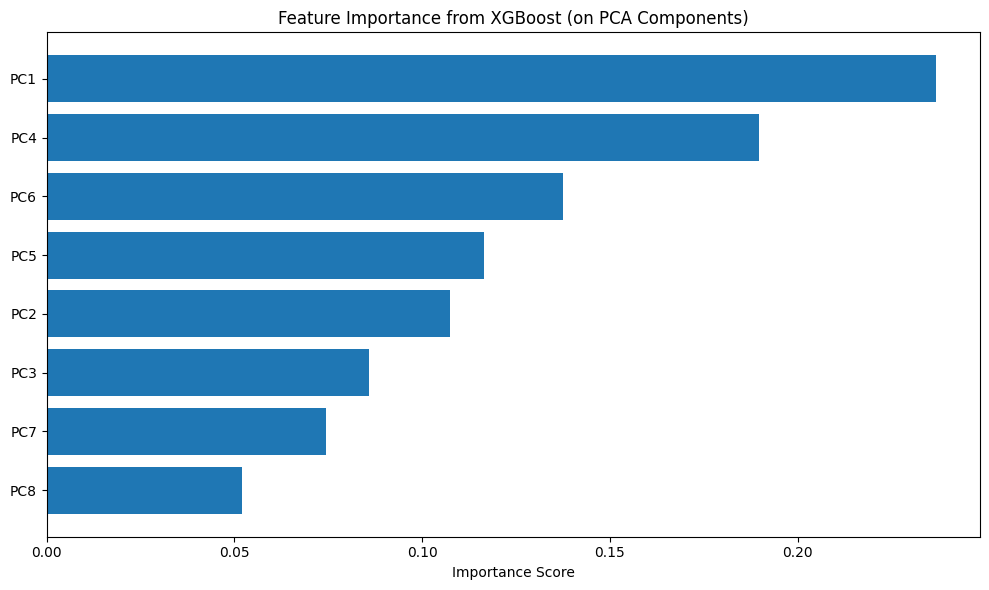

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Get the best pipeline after GridSearchCV
best_pipeline = grid_search.best_estimator_

# Get feature importances from XGBoost
importances = best_pipeline.named_steps['xgb'].feature_importances_

# Generate PCA component names
pca_feature_names = [f'PC{i+1}' for i in range(len(importances))]

# Create DataFrame for importance
feature_importance_df = pd.DataFrame({
    'Feature': pca_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance from XGBoost (on PCA Components)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
